In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import gc
from utils.methods import *
import warnings
warnings.filterwarnings('ignore')

This table lists out the repayment history of each of the loans that the applicant had with Home Credit Group. The table contains features like the amount of installment, how much did the client pay for each installments, etc.

In [4]:
payments = pd.read_csv('../../Dataset/dseb63_final_project_DP_dataset/dseb63_installments_payments.csv')
payments

,SK_ID_PREV,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,SK_ID_CURR
0,1054186,1.0,6,-1180.0,-1187.0,6948.360,6948.360,147397.0
1,2452854,1.0,21,-546.0,-552.0,11302.605,11302.605,147397.0
2,1054186,1.0,2,-1300.0,-1307.0,6948.360,6948.360,147397.0
3,1682318,1.0,2,-240.0,-243.0,7374.510,7374.510,147397.0
4,2452854,1.0,10,-876.0,-882.0,11302.605,11302.605,147397.0
...,...,...,...,...,...,...,...,...
7744753,2192667,1.0,6,-2352.0,-2352.0,5322.240,5322.240,21216.0
7744754,2208281,1.0,4,-452.0,-466.0,63195.435,63195.435,21216.0
7744755,2657771,0.0,3,-2907.0,-2932.0,3375.000,3375.000,21216.0
7744756,2657771,0.0,47,-1871.0,-1871.0,4915.890,4915.890,21216.0


In [5]:
payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7744758 entries, 0 to 7744757
Data columns (total 8 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   SK_ID_PREV              int64  
 1   NUM_INSTALMENT_VERSION  float64
 2   NUM_INSTALMENT_NUMBER   int64  
 3   DAYS_INSTALMENT         float64
 4   DAYS_ENTRY_PAYMENT      float64
 5   AMT_INSTALMENT          float64
 6   AMT_PAYMENT             float64
 7   SK_ID_CURR              float64
dtypes: float64(6), int64(2)
memory usage: 472.7 MB


In [6]:
payments.duplicated().sum()

0

In [7]:
payments.nunique().sum()

2123825

In [8]:
payments.isnull().sum()

SK_ID_PREV                   0
NUM_INSTALMENT_VERSION       0
NUM_INSTALMENT_NUMBER        0
DAYS_INSTALMENT              0
DAYS_ENTRY_PAYMENT        1639
AMT_INSTALMENT               1
AMT_PAYMENT               1639
SK_ID_CURR                   1
dtype: int64

In [9]:
def check_missed_values(df):
    df_null_percentage = df.isnull().sum() / df.shape[0] * 100
    df_null_percentage = df_null_percentage.drop(df_null_percentage[df_null_percentage == 0].index).sort_values(ascending= False).reset_index()
    df_null_percentage.columns = ["Feature", "Percentage"]
    return df_null_percentage

null_df = check_missed_values(payments)

<Axes: xlabel='Percentage', ylabel='Feature'>

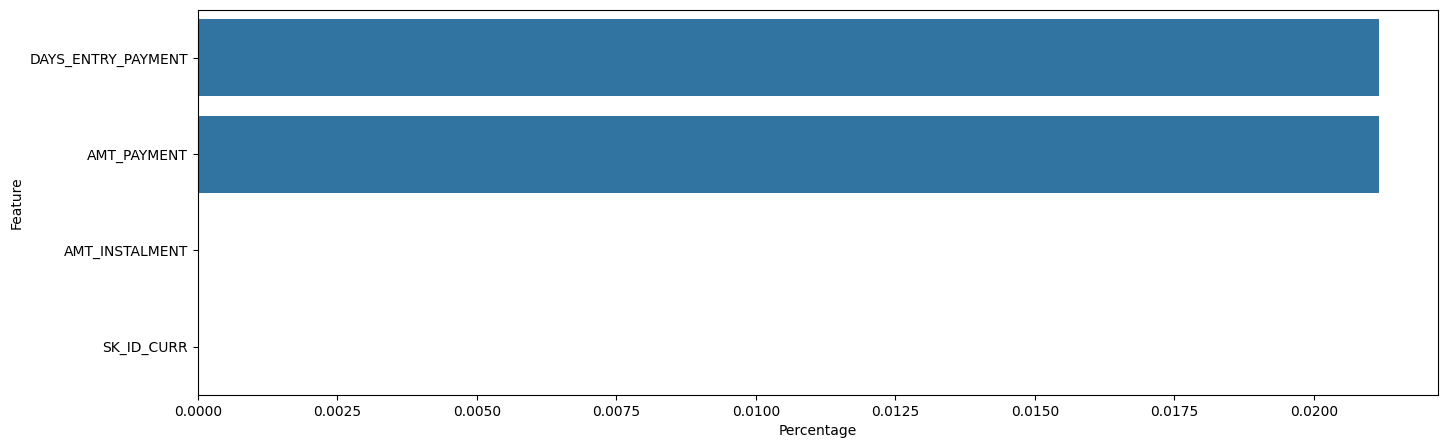

In [10]:
plt.figure(figsize=(16,5))
sns.barplot(x=  null_df["Percentage"] , y= null_df["Feature"] )

There are only 2 columns which contain NaN values of the 8 columns from installments_payments.
These columns also contain very minimal proportion of NaN values, i.e only 0.02%, so it is not of much concern.

In [11]:
# Fill null value in installment payment:
payments['DAYS_ENTRY_PAYMENT'] = payments['DAYS_ENTRY_PAYMENT'].fillna(0)
payments['AMT_PAYMENT'] = payments['AMT_PAYMENT'].fillna(0)
payments['AMT_INSTALMENT'] = payments['AMT_INSTALMENT'].fillna(0)
payments.isnull().sum(axis=0)

SK_ID_PREV                0
NUM_INSTALMENT_VERSION    0
NUM_INSTALMENT_NUMBER     0
DAYS_INSTALMENT           0
DAYS_ENTRY_PAYMENT        0
AMT_INSTALMENT            0
AMT_PAYMENT               0
SK_ID_CURR                1
dtype: int64

In [12]:
train = pd.read_csv('../../Dataset/dseb63_final_project_DP_dataset/dseb63_application_train.csv')
pre = pd.read_csv('../../Dataset/dseb63_final_project_DP_dataset/dseb63_previous_application.csv')

In [13]:
#join 2 table installment payment and application_train qua previous application
#join train voi previous app
train_pre = pd.merge(train, pre, on = 'SK_ID_CURR')
train_pre_copy = train_pre[['TARGET', 'SK_ID_PREV']]
pay = pd.merge(train_pre_copy, payments, on='SK_ID_PREV')

In [14]:
# Group by 'SK_ID_PREV' and 'NUM_INSTALMENT_NUMBER', then sum 'AMT_PAYMENT'
payment_grouped = pay.groupby(['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'])['AMT_PAYMENT'].sum().reset_index()
payment_grouped.rename(columns={'AMT_PAYMENT': 'AMT_PAYMENT_GROUPED'}, inplace=True)

# Merge 'AMT_PAYMENT_GROUPED' back to the 'pay' dataframe
pay = pd.merge(pay, payment_grouped, on=['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'], how='left')

# Calculate new features
pay['PAYMENT_DIFFERENCE'] = pay['AMT_INSTALMENT'] - pay['AMT_PAYMENT_GROUPED']
pay['PAYMENT_RATIO'] = pay['AMT_INSTALMENT'] / pay['AMT_PAYMENT_GROUPED']
pay['PAID_OVER_AMOUNT'] = pay['AMT_PAYMENT'] - pay['AMT_INSTALMENT']
pay['PAID_OVER'] = (pay['PAID_OVER_AMOUNT'] > 0).astype(int)

# Payment Entry: Days past due and Days before due
pay['DPD'] = (pay['DAYS_ENTRY_PAYMENT'] - pay['DAYS_INSTALMENT']).apply(lambda x: max(0, x))
pay['DBD'] = (pay['DAYS_INSTALMENT'] - pay['DAYS_ENTRY_PAYMENT']).apply(lambda x: max(0, x))

# Flag late payment
pay['LATE_PAYMENT'] = (pay['DBD'] > 0).astype(int)

# Percentage of payments that were late
pay['INSTALMENT_PAYMENT_RATIO'] = pay['AMT_PAYMENT'] / pay['AMT_INSTALMENT']

# Flag late payments that have a significant amount
pay['SIGNIFICANT_LATE_PAYMENT'] = (pay['INSTALMENT_PAYMENT_RATIO'] > 0.05).astype(int)

# Flag k threshold late payments
pay['DPD_7'] = (pay['DPD'] >= 7).astype(int)
pay['DPD_15'] = (pay['DPD'] >= 15).astype(int)
pay['INS_IS_DPD_UNDER_120'] = ((pay['DPD'] > 0) & (pay['DPD'] < 120)).astype(int)
pay['INS_IS_DPD_OVER_120'] = (pay['DPD'] >= 120).astype(int)

In [15]:
pay_default = pay[pay['TARGET']==1]
pay_non_default = pay[pay['TARGET']==0]

DAYS_INSTALMENT

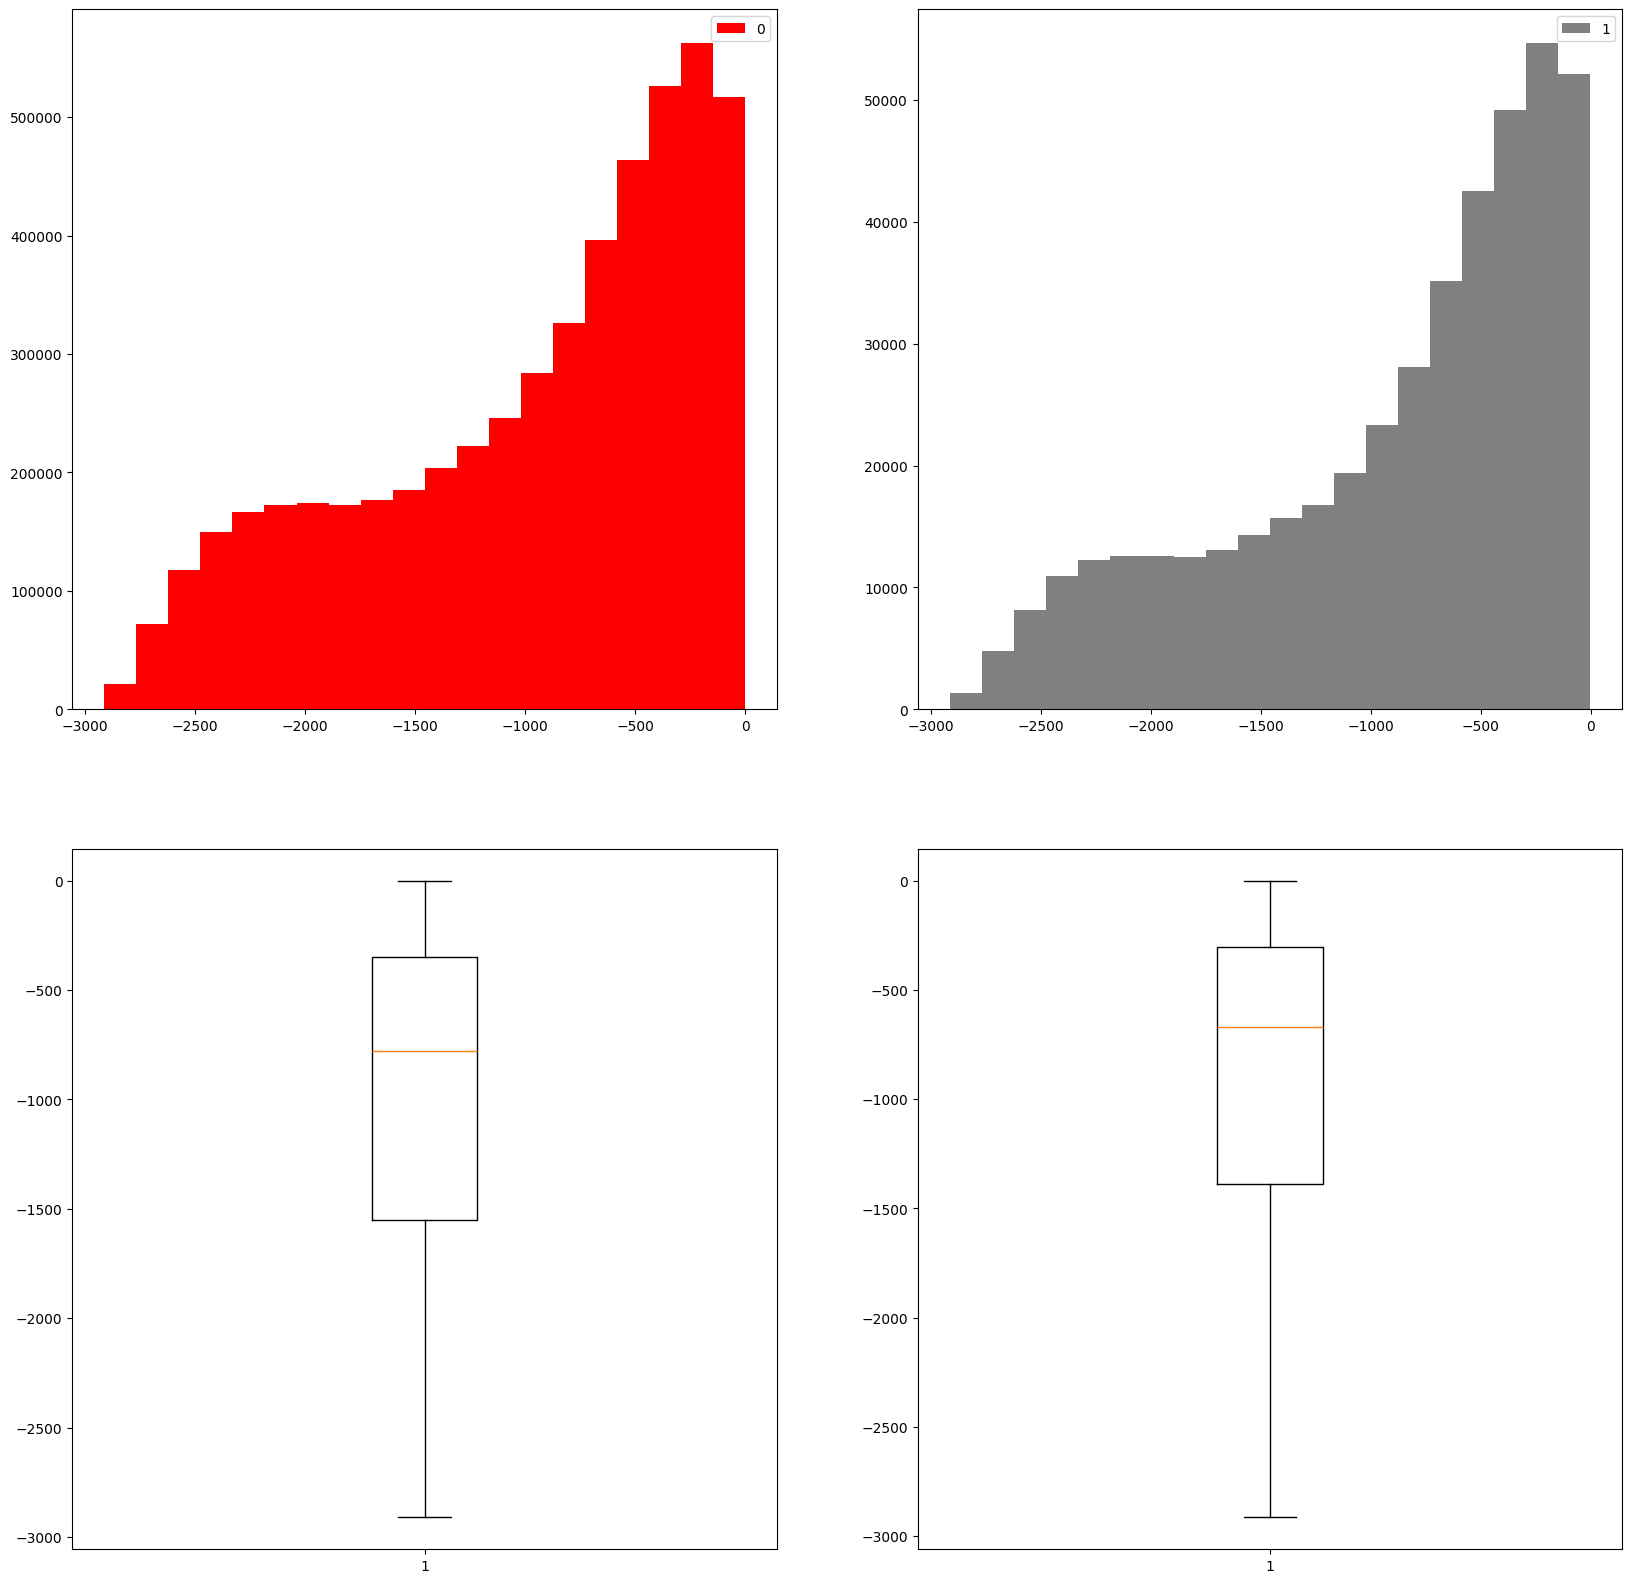

In [16]:
fig,ax = plt.subplots(2,2,figsize = (20,20))
a1 = pay[pay['TARGET'] == 0][['DAYS_INSTALMENT']]
ax[0][0].hist(a1,bins = 20,label = '0', color = 'red')
ax[0][0].legend()
ax[1][0].boxplot(a1)
a2 = pay[pay['TARGET'] == 1][['DAYS_INSTALMENT']]
ax[0][1].hist(a2,bins = 20,label = '1', color = 'grey')
ax[0][1].legend()
ax[1][1].boxplot(a2);

Distribution of DAYS_INSTALMENT on 2 classes are quite similar

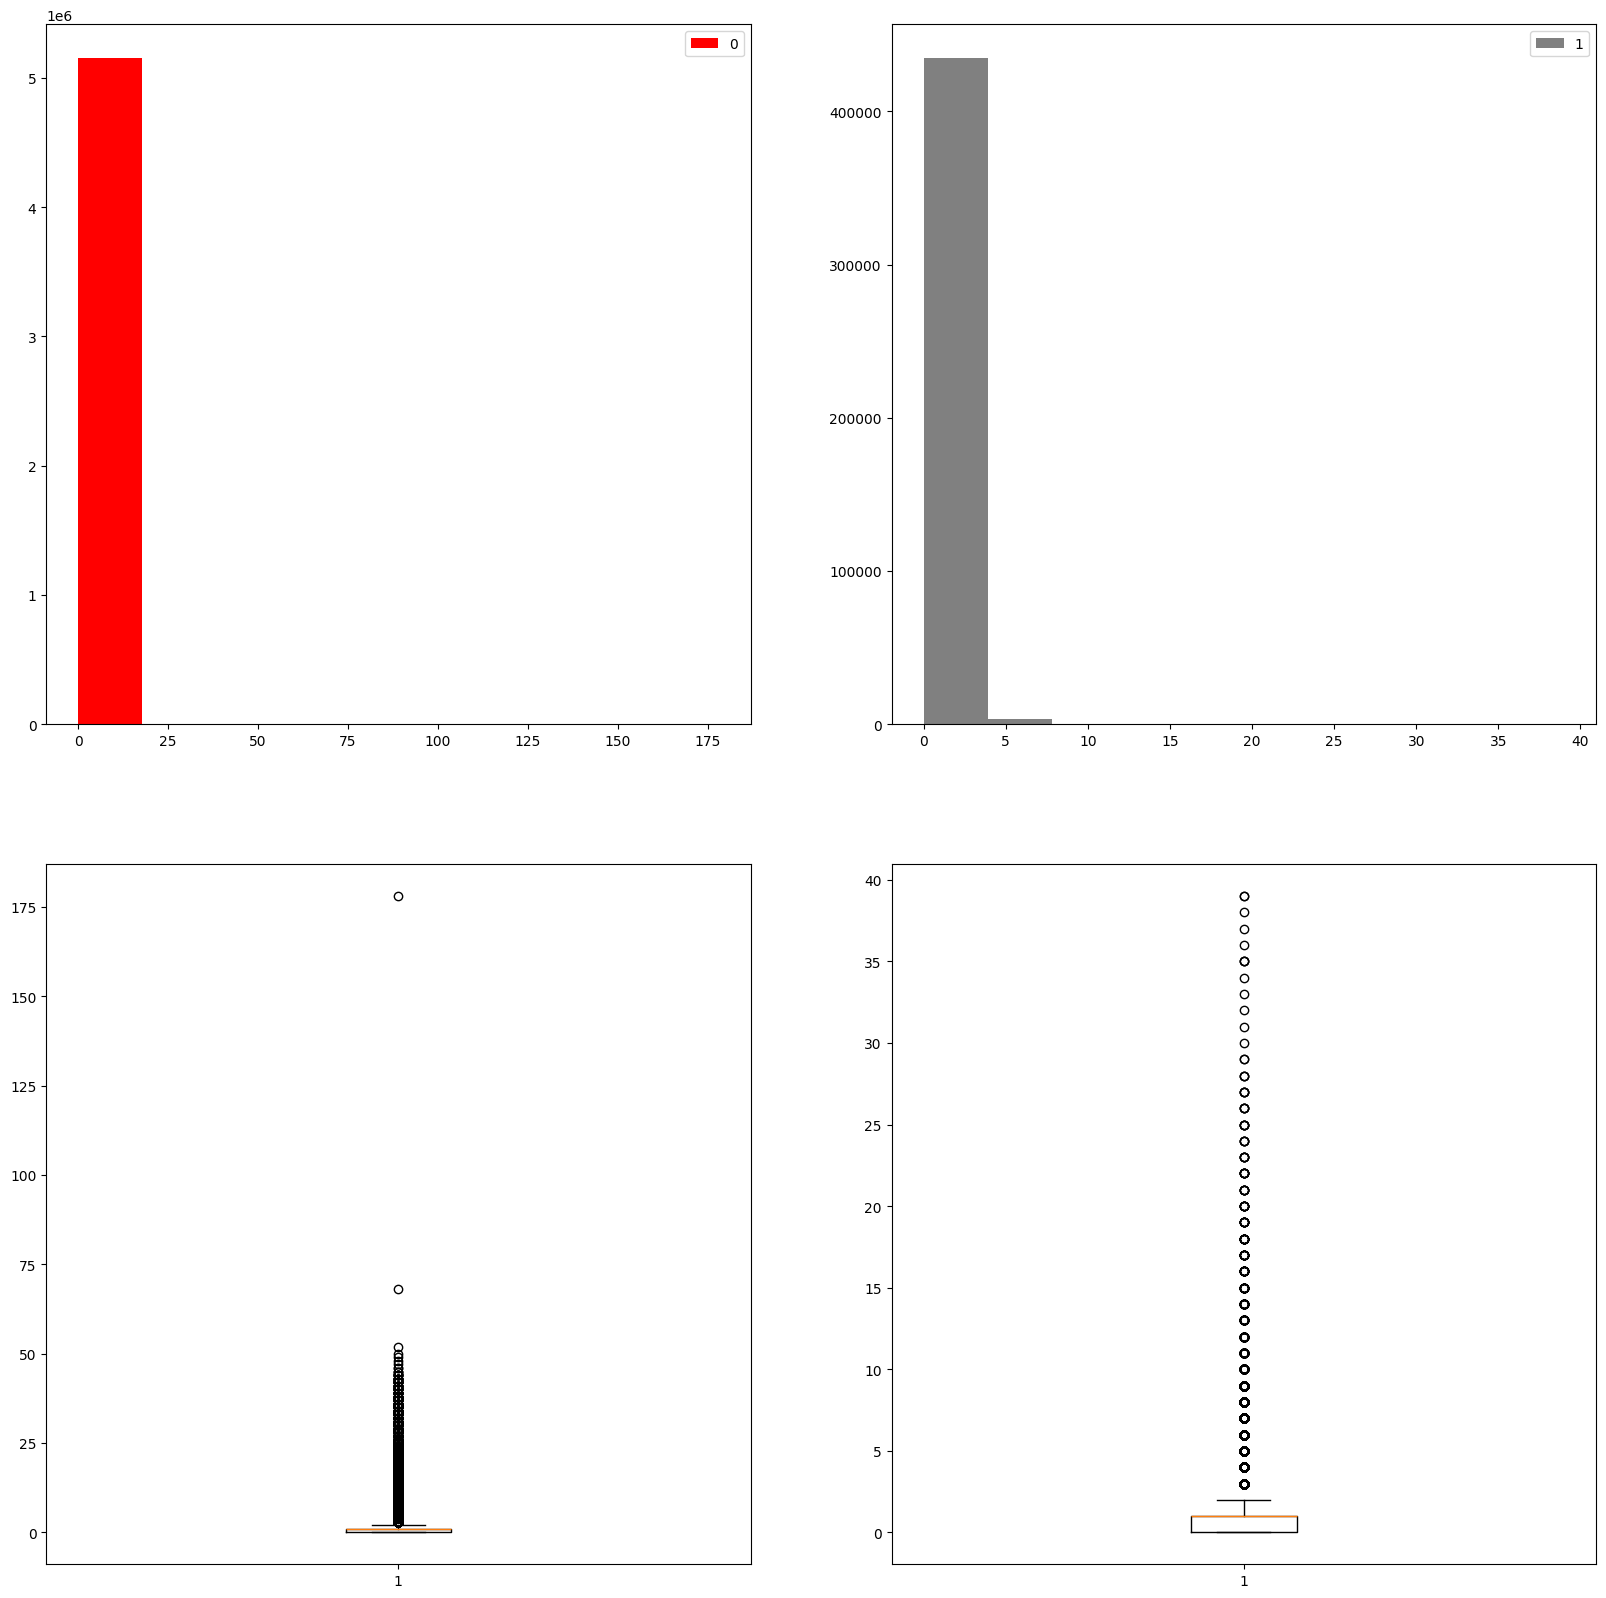

In [17]:
#NUM_INSTALMENT_VERSION - Histogram
fig,ax = plt.subplots(2,2,figsize = (20,20))
a1 = pay[pay['TARGET'] == 0][['NUM_INSTALMENT_VERSION']]
ax[0][0].hist(a1,bins = 10,label = '0', color = 'red')
ax[0][0].legend()
ax[1][0].boxplot(a1)
a2 = pay[pay['TARGET'] == 1][['NUM_INSTALMENT_VERSION']]
ax[0][1].hist(a2,bins = 10,label = '1', color = 'grey')
ax[0][1].legend()
ax[1][1].boxplot(a2);

Numbers of instalment of non-defaulter got a wider range [0, 45] while defaulter got smaller range [0, 4]

In [18]:
visualize = BivariateAnalysis()

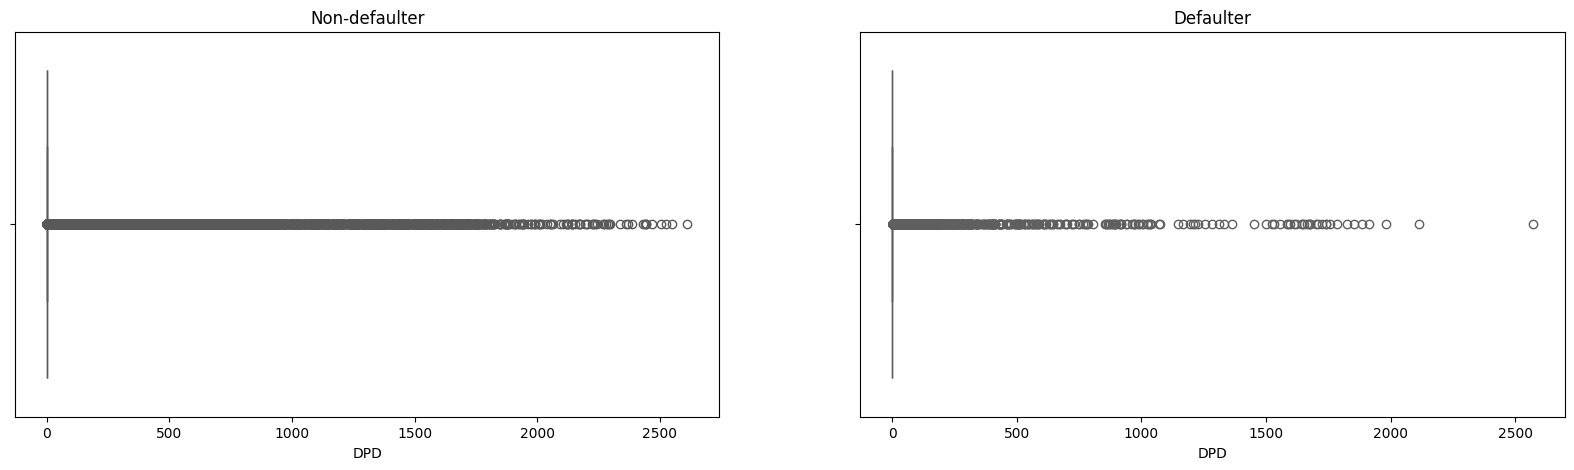

In [19]:
# Trả nợ quá hạn
visualize.box_plot2(x="DPD", df1= pay_non_default, df2=pay_default, width= 20, height=5)

The non-default group has a higher density of late payments (within the range of 1 - 1750 days) compared to the default group (within the range of 0-800 days)

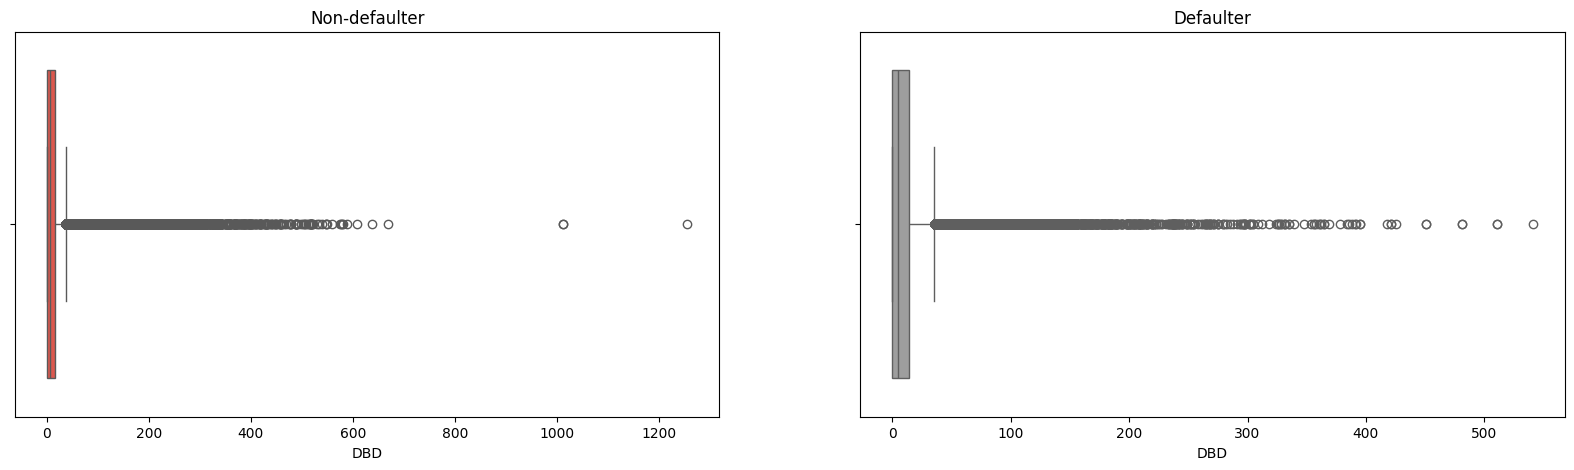

In [20]:
# Trả nợ trước hạn
visualize.box_plot2(x="DBD", df1= pay_non_default, df2=pay_default, width = 20, height=5)

- he number of days paid before due, we observe that the quantile range of the default group is larger than that of the non-default group. Additionally, the non-default group tends to pay earlier, with a relatively higher density of payments falling within the range of 50-400 days compared to the default group.
- The non-default group shows a higher tendency to pay debts before the due date compared to the default group.

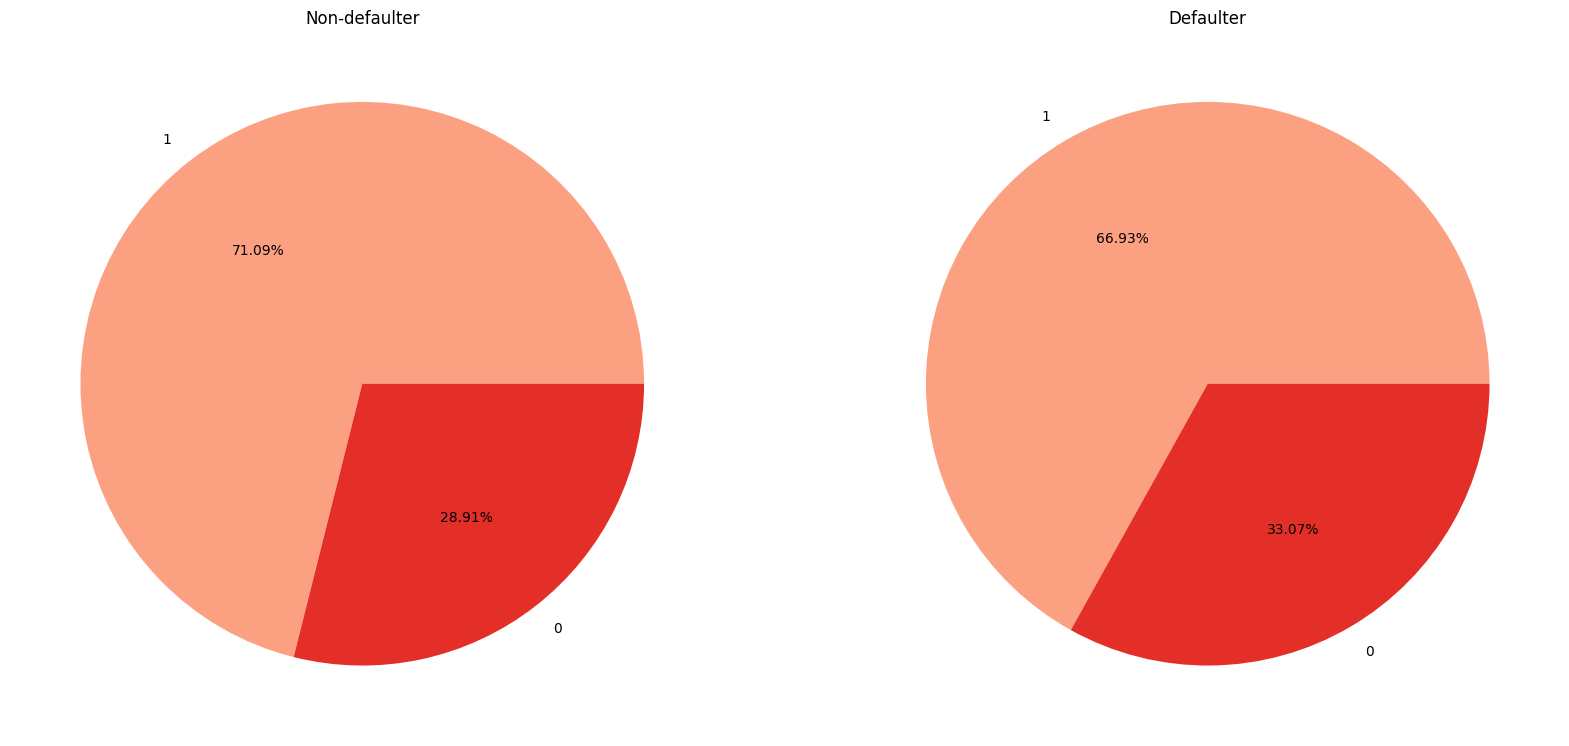

In [21]:
visualize.pie_plot(x='LATE_PAYMENT', df1=pay_non_default, df2=pay_default, width= 20, height=20)

The late payment rates between the default and non-default groups do not differ significantly, with only a slight gap of approximately 5%.

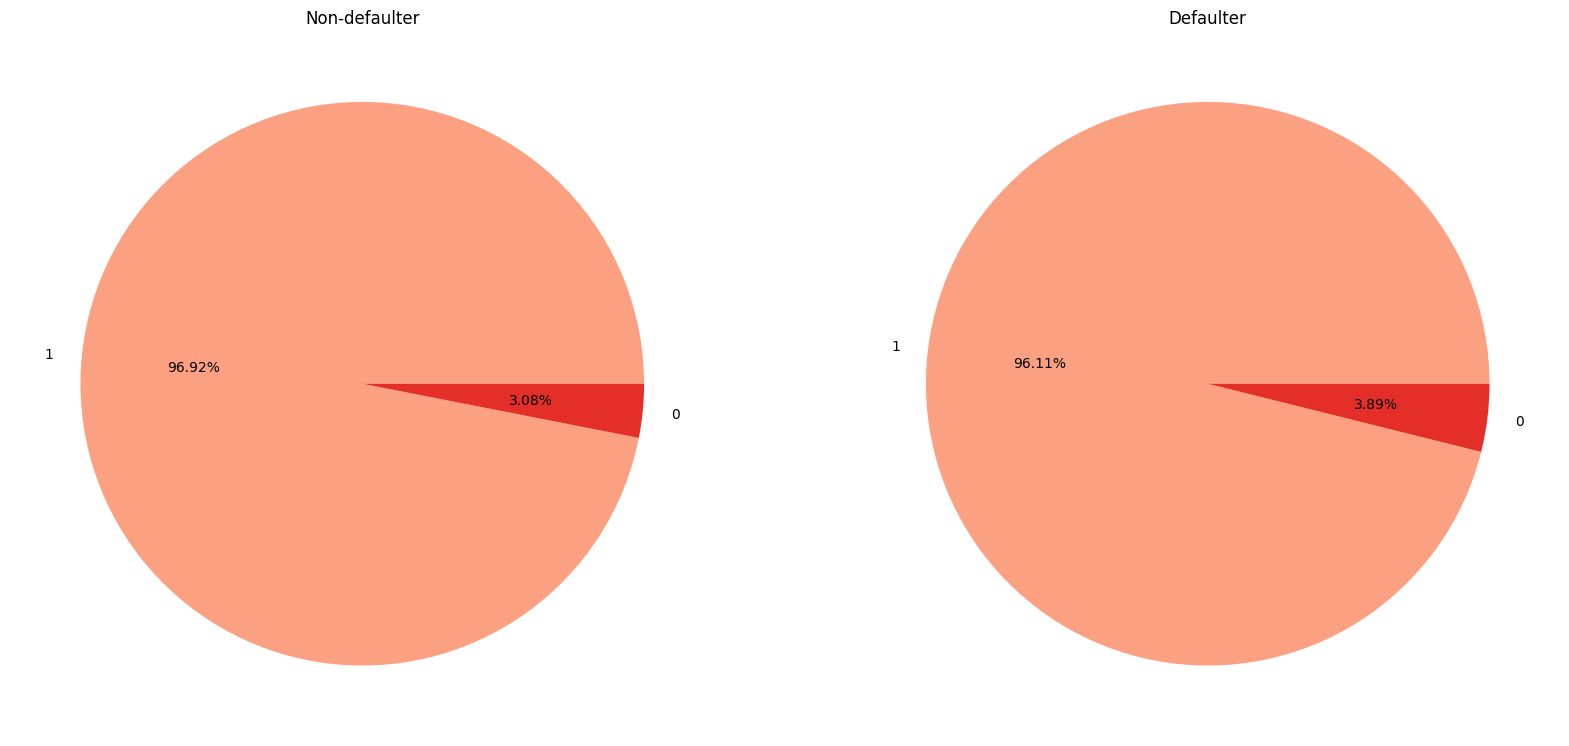

In [22]:
visualize.pie_plot(x='SIGNIFICANT_LATE_PAYMENT', df1=pay_non_default, df2=pay_default, width= 20, height=20)

Loans with a ratio of actual to nominal repayments of less than 5% (indicating less than 5% of the required repayment has been made) are more prevalent in the default group compared to the non-default group.

**Based on the analysis of early and late repayment times:**

- Loans with shorter repayment times (both before and after the due date) are typically credit card loans.
- Loans with longer repayment times (both before and after the due date) may include vehicle loans, mortgage loans, or large-scale credit purposes (long-term investments, real estate purchases).
- Short-term debt can be classified into three categories based on overdue timeframes (7, 15, 120 days):
  - 7 and 15 days: Typically associated with credit card loans.
  - 120 days: Associated with long-term loans.
  - Furthermore, if converted from days to months, it could be considered to categorize loans into:
      - Short-term: Less than 1 year (12 months)
      - Medium-term: Over 1 year and less than 5 years (between 30-60 months)
      - Long-term: Over 5 years


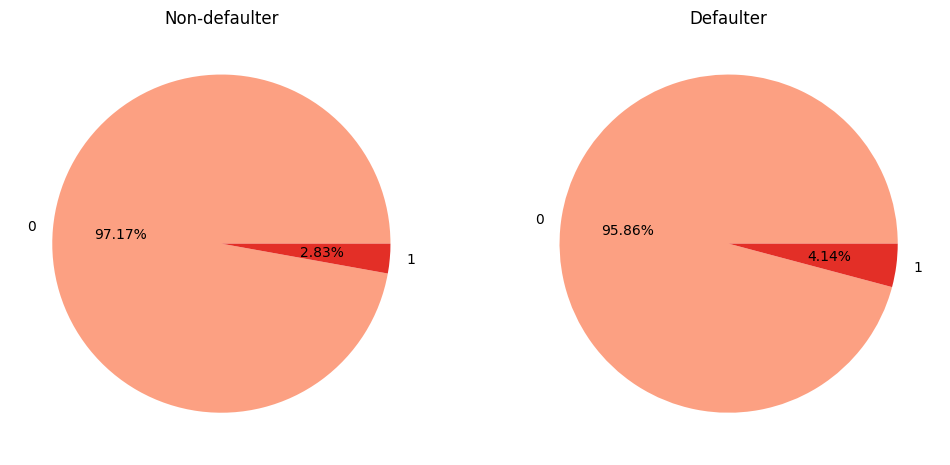

In [23]:
visualize.pie_plot(x='DPD_7', df1= pay_non_default, df2=pay_default)

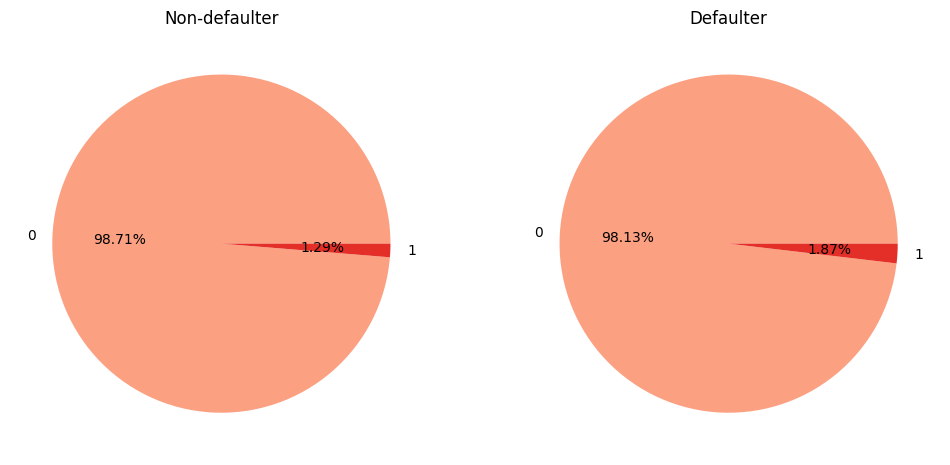

In [24]:
visualize.pie_plot(x='DPD_15', df1= pay_non_default, df2=pay_default)

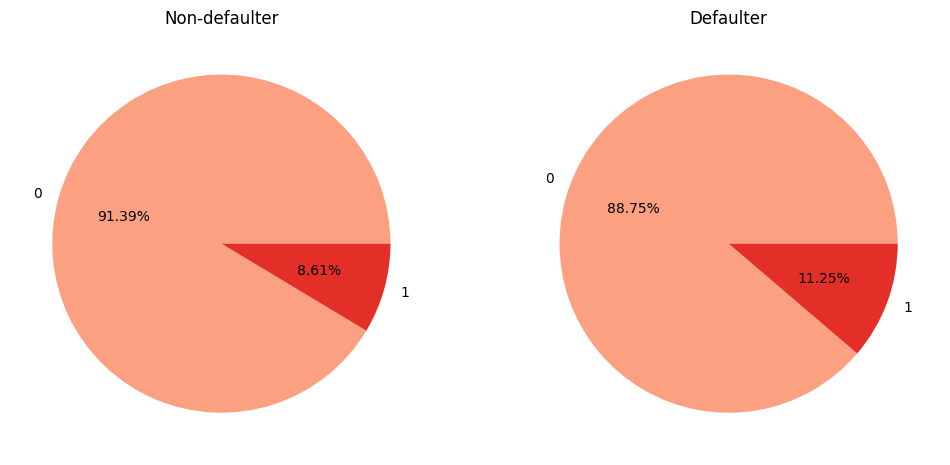

In [25]:
visualize.pie_plot(x='INS_IS_DPD_UNDER_120', df1= pay_non_default, df2=pay_default)